# The Split-Apply-Combine Pattern in Data Science and Python

## Tobias Brandt

<img src="img/argon_logo.png" align=left width=200>

<!-- <img src="http://www.argonassetmanagement.co.za/css/img/logo.png" align=left width=200> -->

<img src='img/argon_website.png' align='middle'>

### Projected number of talk attendees

  * With "Data Science" in title 
      * 10 +/- 5
  * vs without "Data Science" in title
      * 20 +/- 5
  * insert xkcd style chart

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0860A330>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x08664770>]], dtype=object)

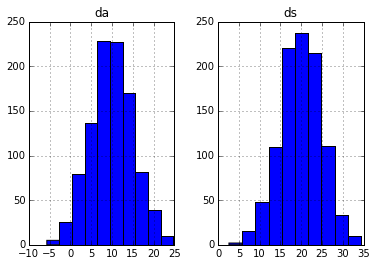

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

n = 1000
df = pd.DataFrame(dict(da = 10+5*np.random.randn(n), ds = 20+5*np.random.randn(n)))
df.hist()

### Google trends chart

!["data science" vs "data analysis"](img/data_science_vs_data_analysis.png)

## Data Science

According to https://en.wikipedia.org/wiki/Data_science:

In November 1997, C.F. Jeff Wu gave the inaugural lecture entitled **"Statistics = Data Science?"**[5] for his appointment to the H. C. Carver Professorship at the University of Michigan.[6] In this lecture, he characterized statistical work as a trilogy of **data collection**, **data modeling and analysis**, and **decision making**. In his conclusion, he initiated the modern, non-computer science, usage of the term "data science" and advocated that statistics be renamed data science and statisticians data scientists.[5]

## The Github Archive Dataset

https://www.githubarchive.org/

Open-source developers all over the world are working on millions of projects: writing code & documentation, fixing & submitting bugs, and so forth. GitHub Archive is a project to record the public GitHub timeline, archive it, and make it easily accessible for further analysis.

GitHub provides 20+ event types, which range from new commits and fork events, to opening new tickets, commenting, and adding members to a project. These events are aggregated into hourly archives, which you can access with any HTTP client:

  * gzipped json files
  * yyyy-mm-dd-HH.json.gz

In [2]:
import os
import gzip
import ujson as json

directory = 'data/github_archive'
filename = '2015-01-29-16.json.gz'

path = os.path.join(directory, filename)
with gzip.open(path) as f:
        events = [json.loads(line) for line in f]
#print json.dumps(events[0], indent=4)

<pre>
{
    <b>"payload": {</b>
        "master_branch": "master", 
        "ref_type": "branch", 
        "ref": "disable_dropdown", 
        "description": "OOI UI Source Code", 
        "pusher_type": "user"
    }, 
    <b>"created_at": "2015-01-29T16:00:00Z", </b>
    "actor": {
        "url": "https://api.github.com/users/birdage", 
        <b>"login": "birdage", </b>
        "avatar_url": "https://avatars.githubusercontent.com/u/547228?", 
        "id": 547228, 
        "gravatar_id": ""
    }, 
    "id": "2545235518", 
    "repo": {
        "url": "https://api.github.com/repos/birdage/ooi-ui", 
        "id": 23796192, 
        <b>"name": "birdage/ooi-ui"</b>
    }, 
    <b>"type": "CreateEvent", </b>
    "public": true
}
</pre>

### Typical Questions

  * How many Github repositories are created per hour/day/month?
  * To which repositories are the most commits are pushed per hour/day/month?
  * Which projects receive the most pull requests?
  * What are the most popular languages on Github?

## Example 1 - Number of Repositories Created

In [3]:
new_repo_count = 0
for event in events:
    new_repo_count += \
        1 if event['type']=="CreateEvent" else 0

In [4]:
print new_repo_count

3516


## Example 2 - Number of commits pushed per repository

In [5]:
repo_commits = {}
for event in events:
    if event['type']=="PushEvent":
        repo = event['repo']['name']
        commits = event['payload']['size']
        repo_commits[repo] = \
            repo_commits.get(repo, 0) + commits 

In [6]:
def print_top_items(dct, N=5):
    sorted_items = sorted(
        dct.iteritems(), key=lambda t: t[1], reverse=True)
    for key, value in sorted_items[:N]:
        print "{:40} {}".format(key, value)

print_top_items(repo_commits)

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


# The Split-Apply-Combine Pattern

## Hadley Wickham <img src="http://pix-media.s3.amazonaws.com/blog/1001/HadleyObama.png" width=250 align=left>

[Hadley Wickham, the man who revolutionized R](http://priceonomics.com/hadley-wickham-the-man-who-revolutionized-r/)

*If you don’t spend much of your time coding in the open-source statistical programming language R, 
his name is likely not familiar to you -- but the statistician Hadley Wickham is, 
in his own words, “nerd famous.” The kind of famous where people at statistics conferences 
line up for selfies, ask him for autographs, and are generally in awe of him. 

In [7]:
from IPython.display import HTML
HTML('<iframe src="http://www.jstatsoft.org/v40/i01" width=800 height=400></iframe>')

<img src="http://i.imgur.com/CoJHnAF.jpg">

  * StackOverflow: [split-apply-combine tag](http://stackoverflow.com/tags/split-apply-combine/info)
  * Pandas documentation: [Group By: split-apply-combine](http://pandas.pydata.org/pandas-docs/stable/groupby.html)
  * PyTools documentation: [Split-apply-combine with groupby and reduceby](http://toolz.readthedocs.org/en/latest/streaming-analytics.html#split-apply-combine-with-groupby-and-reduceby)
  * Blaze documentation: [Split-Apply-Combine - Grouping](http://blaze.pydata.org/en/stable/split-apply-combine.html)
  * R plyr: [plyr: Tools for Splitting, Applying and Combining Data](https://cran.r-project.org/web/packages/plyr/index.html)
  * Julia documentation: [The Split-Apply-Combine Strategy](https://dataframesjl.readthedocs.org/en/latest/split_apply_combine.html)

## The Basic Pattern

 1. **Split** the data by some **grouping variable**
 2. **Apply** some function to each group **independently**
 3. **Combine** the data into some output dataset

  * The **apply** step is usually one of
      * **aggregate**
      * **transform**
      * or **filter**

### Example 2 - examined

In [8]:
repo_commits = {}
for event in events:
    if event['type']=="PushEvent":
        repo = event['repo']['name']
        commits = event['payload']['size']
        repo_commits[repo] = \
            repo_commits.get(repo, 0) + commits 
print_top_items(repo_commits)

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


This

  * filters out only the "PushEvent"s
  * **splits** the dataset by *repository*
  * **sums** the commits for each group
  * **combines** the groups and their sums into a dictionary

# Pandas - Python Data Analysis Library

<p><a href="http://pandas.pydata.org/"><img src="http://pandas.pydata.org/_static/pandas_logo.png" align=right width=400></a></p>

  * Provides high-performance, easy-to-use data structures and data analysis tools.
  * Provides core data structure **DataFrame**

### pandas.DataFrame

  * Basically in-memory database tables (or spreadsheets!)
  * Tabular data that allows for columns of different dtypes
  * Labeled rows and columns (index)
  * Hierarchical indexing allows for representing Panel data

In [9]:
from collections import namedtuple
GithubEvent = namedtuple('GithubEvent', ['type', 'user', 'repo', 'created_at', 'commits'])

def make_record(event):
    return GithubEvent(
        event['type'], event['actor']['login'], 
        event['repo']['name'], pd.Timestamp(event['created_at']),
        event['payload']['size'] if event['type']=='PushEvent' else np.nan
        )

df = pd.DataFrame.from_records(
    (make_record(ev) for ev in events),
    columns=GithubEvent._fields)
df.head()

,type,user,repo,created_at,commits
0,CreateEvent,birdage,birdage/ooi-ui,2015-01-29 16:00:00+00:00,NaN
1,PushEvent,ArniR,ArniR/ArniR.github.io,2015-01-29 16:00:00+00:00,1
2,IssueCommentEvent,CrossEye,ramda/ramda,2015-01-29 16:00:00+00:00,NaN
3,PushEvent,yluoyu,yluoyu/demo,2015-01-29 16:00:00+00:00,1
4,IssueCommentEvent,EJBQ,prmr/JetUML,2015-01-29 16:00:00+00:00,NaN


### Example 1 (using Pandas) - Number of Repositories Created

In [10]:
df[df.type=='CreateEvent'].head()

,type,user,repo,created_at,commits
0,CreateEvent,birdage,birdage/ooi-ui,2015-01-29 16:00:00+00:00,NaN
9,CreateEvent,filipe-maia,Lucas-Andrade/ProjectManager_FLM,2015-01-29 16:00:02+00:00,NaN
11,CreateEvent,filipe-maia,Lucas-Andrade/ProjectManager_FLM,2015-01-29 16:00:02+00:00,NaN
13,CreateEvent,frewsxcv,frewsxcv/gargoyle,2015-01-29 16:00:02+00:00,NaN
17,CreateEvent,schnere,bluevisiontec/GoogleShoppingApi,2015-01-29 16:00:03+00:00,NaN


In [11]:
len(df[df.type=='CreateEvent'])

3516

### Split-Apply-Combine in Pandas

  * Uses **groupby** to
      * **split** the data into groups based on some criteria
      * **apply** a function on each group independently
      * **combining** the results into a data structure

  * The **apply** step is usually one of
      * **aggregate**
      * **transform**
      * or **filter**

In [12]:
HTML('<iframe src="http://pandas.pydata.org/pandas-docs/version/0.16.2/groupby.html" width=800 height=300></iframe>')

### Example 2 (using Pandas) - Number of commits pushed per repo

In [13]:
repo_commits = {}
for event in events:
    if event['type']=="PushEvent":
        repo = event['repo']['name']
        commits = event['payload']['size']
        repo_commits[repo] = \
            repo_commits.get(repo, 0) + commits 
print_top_items(repo_commits)

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


In [14]:
repo_commits = df[df.type=='PushEvent'].groupby('repo').commits.sum()
repo_commits.sort(ascending=False)
repo_commits.head(5)

repo
eberhardt/moodle                   3335
sakai-mirror/melete                3209
jfaris/phonegap-facebook-plugin    3201
sakai-mirror/mneme                 2922
wolfe-pack/wolfe                   2001
Name: commits, dtype: float64

### Example 1 - revisited

In [15]:
event_counts = df.groupby('type').repo.count()
event_counts.sort(ascending=False)
event_counts.head()

type
PushEvent            15443
IssueCommentEvent     3718
CreateEvent           3516
WatchEvent            2682
PullRequestEvent      1891
Name: repo, dtype: int64

Great for interactive work:

  * tab-completion!
  * inspect data with `df.head()` & `df.tail()`
  * quick overview of data ranges with `df.describe()`

<img src="http://i.imgur.com/6b2AF7e.jpg" width=300 align='middle'>

However ...

### Pandas currently only handles in-memory datasets!

### So not suitable for big data!

<img src="img/devops_borat.jpg">

# MapReduce

*"If you want to process Big Data, you need some MapReduce framework like one of the following"*
<p>
<a href="https://hadoop.apache.org/"><img src="https://hadoop.apache.org/images/hadoop-logo.jpg" width=200 align=left></a>
<a href="http://spark.apache.org/"><img src="http://spark.apache.org/images/spark-logo.png" width=100 align=left></a>
</p>

<img src="https://mitpress.mit.edu/sicp/full-text/book/cover.jpg" align=right width=150>

The key to these frameworks is adopting a **functional** [programming] mindset. In Python this means, think **iterators**!

See [The Structure and Interpretation of Computer Programs](https://mitpress.mit.edu/sicp/full-text/book/book.html)
(the "*Wizard book*")

  * in particular [Chapter 2 Building Abstractions with Data](https://mitpress.mit.edu/sicp/full-text/book/book-Z-H-13.html#%_chap_2) 
  * and [Section 2.2.3 Sequences as Conventional Interfaces](https://mitpress.mit.edu/sicp/full-text/book/book-Z-H-15.html#%_sec_2.2.3)

Luckily, the Split-Apply-Combine pattern is well suited to this!  

## Example 1 - revisited

In [16]:
new_repo_count = 0
for event in events:
    new_repo_count += \
        1 if event['type']=="CreateEvent" else 0
print new_repo_count

3516


In [17]:
reduce(lambda x,y: x+y, 
       map(lambda ev: 1 if ev['type']=='CreateEvent' else 0, 
           events))

3516

Would prefer to write

    events | map(...) | reduce(...)

## Example 1 - pipelined

In [18]:
def datapipe(data, *transforms):
    for transform in transforms:
        data = transform(data)
    return data

datapipe(
    events,
    lambda events: map(lambda ev: 1 if ev['type']=='CreateEvent' else 0, events),
    lambda counts: reduce(lambda x,y: x+y, counts)
    )

3516

## PyToolz

## Example 1 - pipeline using PyToolz

In [19]:
from toolz.curried import pipe, map, reduce

pipe(events,
     map(lambda ev: 1 if ev['type']=='CreateEvent' else 0),
     reduce(lambda x,y: x+y)
    )

3516

In [20]:
HTML('<iframe src="https://toolz.readthedocs.org/en/latest/index.html" width=800 height=400></iframe>')

What about **group by** operations?

There is an `itertools.groupby` function in the standard library.

However

  * it requires the data to be sorted,
  * returns iterables which are shared with the original iterable.

Hence I find that I usually need to consult the [documentation](https://docs.python.org/2/library/itertools.html#itertools.groupby) to use it correctly.

Use the `toolz` library rather!

In [21]:
HTML('<iframe src="https://docs.python.org/2/library/itertools.html#itertools.groupby" width=800 height=200></iframe>')

## Example 2 - pipelined with PyToolz

In [22]:
repo_commits = {}
for event in events:
    if event['type']=="PushEvent":
        repo = event['repo']['name']
        commits = event['payload']['size']
        repo_commits[repo] = \
            repo_commits.get(repo, 0) + commits 
print_top_items(repo_commits)

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


In [23]:
from toolz.curried import filter, reduceby
pipe(events,
     filter(lambda ev: ev['type']=='PushEvent'),
     reduceby(lambda ev: ev['repo']['name'],
              lambda commits, ev: commits+ev['payload']['size'],
              init=0),
     print_top_items
     )

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


In [24]:
from toolz import groupby, valmap, filter
repo_commits = \
    valmap(lambda lst: sum(map(lambda ev: ev['payload']['size'], lst)),
       groupby(lambda ev: ev['repo']['name'],
               filter(lambda ev: ev['type']=='PushEvent', 
                      events)
              )
      )
print_top_items(repo_commits)

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


### Example 2 - pipelined

In [25]:
from toolz.curried import pipe, groupby, valmap, filter, map, get, compose
pipe(events,
     filter(lambda ev: ev['type']=='PushEvent'),
     groupby(lambda ev: ev['repo']['name']),
     valmap(compose(sum, 
                    map(lambda ev: ev['payload']['size']))),
     print_top_items
     )

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


In [26]:
HTML('<iframe src="https://toolz.readthedocs.org/en/latest/streaming-analytics.html#streaming-split-apply-combine" width=800 height=300></iframe>')

In [27]:
def inc(dct, key):
    dct[key] = dct.get(key, 0) + 1
    return dct


### The Point of Learning Patterns

From Cosma Shalizi's [Statistical Computing](http://www.stat.cmu.edu/~cshalizi/statcomp/13/lectures/12/lecture-12.pdf) course:
  
  * Distinguish between **what** you want to do and **how you want to do it**.
  * Focusing on **what** brings clarity to intentions.
  * **How** also matters, but can obscure the high level problem.
 
 Learn the pattern, recognize the pattern, love the pattern!
 
 Re-use *good* solutions!

### Iteration Considered Unhelpful

Could always do the same thing with `for` loops, but those are
  
  * *verbose* - lots of "how" obscures the "what"
  * painful/error-prone bookkeeping (indices, placeholders, ...)
  * clumsy - hard to parallelize

## Out-of-core processing - toolz example

In [28]:
def count_commits(filename):
    import gzip
    import json
    from toolz.curried import pipe, filter, reduceby
    with gzip.open(filename) as f:
        repo_commits = pipe(
            map(json.loads, f),
            filter(lambda ev: ev['type']=='PushEvent'),
            reduceby(lambda ev: ev['repo']['name'],
                     lambda commits, e: commits+e['payload']['size'],
                     init=0)
                     )
    return repo_commits
print_top_items(count_commits(path))

eberhardt/moodle                         3335
sakai-mirror/melete                      3209
jfaris/phonegap-facebook-plugin          3201
sakai-mirror/mneme                       2922
wolfe-pack/wolfe                         2001


In [29]:
import glob
files = glob.glob('C:/ARGO/talks/split-apply-combine/data/github_archive/2015-01-*')
print len(files)
N = 24  #len(files)    # 10

744


In [30]:
%%time
from toolz.curried import reduceby
from __builtin__ import map as pmap
repo_commits = \
    pipe(pmap(count_commits, files[:N]),
         lambda lst: reduce(lambda out, dct: out + dct.items(), lst, []),
         reduceby(lambda t: t[0], lambda s,t: s+t[1], init=0)
         )
print_top_items(repo_commits)

sakai-mirror/melete                      77016
sakai-mirror/mneme                       70128
sakai-mirror/ambrosia                    18480
jsonn/pkgsrc                             17629
devhd/rulus                              9890
Wall time: 15.5 s


In [31]:
%%time
# Remember to start the ipcluster!
# ipcluster start -n 4
from IPython.parallel import Client
p = Client()[:]
pmap = p.map_sync
repo_commits = \
    pipe(pmap(count_commits, files[:N]),
         lambda lst: reduce(lambda out, dct: out + dct.items(), lst, []),
         reduceby(lambda t: t[0], lambda s,t: s+t[1], init=0)
         )
print_top_items(repo_commits)

sakai-mirror/melete                      77016
sakai-mirror/mneme                       70128
sakai-mirror/ambrosia                    18480
jsonn/pkgsrc                             17629
devhd/rulus                              9890
Wall time: 4.93 s


# New tools

## [Blaze](http://blaze.pydata.org/en/latest/) 

<img src="img/blaze_med.png" width=400>


## [Dask](http://dask.pydata.org/en/latest/)

<img src="img/dask-collections-schedulers.png">

## Blaze

In [32]:
categories = ['type', 'user', 'repo']
def to_df(filename):
    with gzip.open(filename) as f:
        events = map(json.loads, f)
        records = map(make_record, events)
        df = pd.DataFrame.from_records(
            records, columns=GithubEvent._fields)
    for col in categories:
        df[col] = df[col].astype('category')
    return df.set_index('created_at')
df = to_df(files[0])
df.head()

,type,user,repo,commits
created_at,,,,
2015-01-01 00:00:00+00:00,PushEvent,davidjhulse,davidjhulse/davesbingrewardsbot,1
2015-01-01 00:00:00+00:00,PushEvent,jmoon018,jmoon018/rshell-unit-tester,1
2015-01-01 00:00:01+00:00,CreateEvent,christoferpeterson,christoferpeterson/Vadek,NaN
2015-01-01 00:00:01+00:00,PushEvent,JakeWharton,square/okhttp,8
2015-01-01 00:00:03+00:00,PushEvent,git4ruby,git4ruby/movie_review1,1


In [ ]:
repo_commits = df[df.type=='PushEvent'].groupby('repo').commits.sum()
repo_commits.sort(ascending=False)
repo_commits.head(5)

In [37]:
from blaze import Symbol
event = Symbol('github_event', 'var * {created_at: timestamp, type: string, user: string, repo: string, commits: int}')
repo_commits = event[event.type=='PushEvent'].groupby('repo').commits.sum()

DataShapeSyntaxError: 

  File <nofile>, line 1
    var * {created_ad: timestamp, type: string, user: string, repo: string, commits: int}
                       ^

DataShapeSyntaxError: Expected the datashape of the field


In [ ]:
bz.

In [35]:
from blaze import DataFrame, by
data = DataFrame(df)
by(data.user, counts=data.repo.count())

NotImplementedError: Could not find signature for by: <Series>

## Dask and Castra

In [ ]:
from castra import Castra
castra = Castra('data/github_archive.castra',
                template=df, categories=categories)
castra.extend_sequence(map(to_df, files), freq='1h')

In [ ]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

df = dd.from_castra('data/github_archive.castra')
df.head()

In [ ]:
df.type.value_counts().nlargest(5).compute()

In [ ]:
df[df.type=='PushEvent'].groupby('repo').commits.resample('h', how='count').compute()

## So ...

<img src='img/calm.jpg' width=300 align='middle'>

# ... in Python!

# Thank you!

## We're hiring!

  * I'm [snth](http://github.com/snth) on github
  * The Jupyter Notebook is on github: [github.com/snth/split-apply-combine](http://github.com/snth/split-apply-combine)
  * You can view the slides on nbviewer: [slides](http://nbviewer.ipython.org/format/slides/github/snth/split-apply-combine/blob/master/The%20Split-Apply-Combine%20Pattern%20in%20Data%20Science%20and%20Python.ipynb#/)